In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from skimage import color, util, transform as trans, filters, feature, segmentation, morphology
from scipy import ndimage, signal
from sklearn import cluster

In [266]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1, names=False):
    fnames = np.random.choice(os.listdir(images_path), k)
    images = tuple(map(get, fnames))
    if names: return images, fnames
    else: return images

def hsv_gray(image):
    return color.rgb2gray(color.rgb2hsv(image))

def freqs(image):
    w, h = image.shape
    freq_x = np.fft.fftfreq(w, 1)
    freq_y = np.fft.fftfreq(h, 1)
    fft_x = np.abs(np.fft.fft(np.nansum(image, axis=1)))
    fft_y = np.abs(np.fft.fft(np.nansum(image, axis=0)))
    vals_x, vals_y = freq_x[fft_x == np.sort(fft_x)[-2]], freq_y[fft_y == np.sort(fft_y)[-2]]
    return np.abs(vals_x[0]), np.abs(vals_y[0])

def levels(image, f=np.nansum):
    return f(image, axis=0), f(image, axis=1)

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def ftfilter(fft, xi=0, xf=1, yi=0, yf=1):
    xi, xf = int(xi*fft.shape[0]), int(xf*fft.shape[0])
    yi, yf = int(yi*fft.shape[1]), int(yf*fft.shape[1])
    x, y = np.meshgrid(np.arange(0, fft.shape[0]), np.arange(0, fft.shape[1]))
    f = np.vectorize(lambda x, y: xi <= x <= xf and yi <= y <= yf)
    return np.where(f(x, y), fft, 0)

def radfilter(fft, rf, ri=0):
    x, y = np.meshgrid(np.arange(0, fft.shape[0]), np.arange(0, fft.shape[1]))
    R = np.sqrt((x - fft.shape[0])**2 + (y - fft.shape[1])**2)
    return np.where(np.logical_and(ri <= R, R <= rf), fft, 0)

def seg1(img):
    img = filters.farid(img)
    for i in range(5):
        kn = (10+i, 10+i)
        im_mean = ndimage.uniform_filter(img, kn)
        im_sqr_mean = ndimage.uniform_filter(img**2, kn)
        im_var = ndimage.minimum_filter((im_sqr_mean - im_mean**2), (i, i))
    data = im_var.flatten()
    km = cluster.KMeans(3)
    cluster_id = km.fit_predict(data.reshape(-1, 1))
    min_bin = None
    f = 0
    for ii in np.unique(cluster_id):
        subset = data[cluster_id == ii]
        hist, bins = np.histogram(subset, bins=50)
        if min_bin == None or bins.max() < min_bin:
            min_bin = bins.max()
            f = bins[:-1][hist == hist.min()][-1]
    imth = im_var < min_bin
    mask = ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
    return mask

def freq_peaks(image):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = ypeaks[ymean[ypeaks] == ymean[ypeaks][np.isin(ymean[ypeaks], ymean[yfreqs < yfreqs[ymean == ymean[ypeaks].max()][0]])].max()]
    Px = xpeaks[xmean[xpeaks] == xmean[xpeaks][np.isin(xmean[xpeaks], xmean[xfreqs < xfreqs[xmean == xmean[xpeaks].max()][0]])].max()]
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

# Fourier 2D

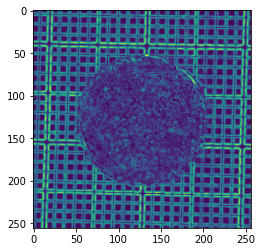

In [252]:
image = by_id(112)
img = filters.farid(color.rgb2gray(image))
plt.imshow(img)

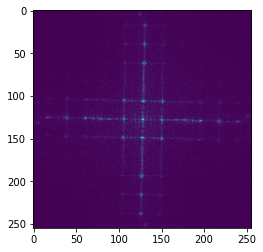

In [253]:
FFT = fft2d(img)
fft = np.abs(FFT)
xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
plt.imshow(fft[(xfreqs != 0) & (yfreqs != 0)])

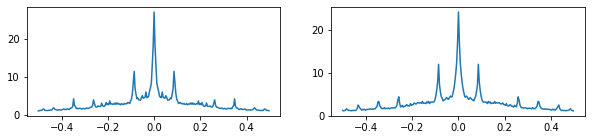

In [254]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))
xmean = np.mean(fft, axis=0)
ymean = np.mean(fft, axis=1)
ax1.plot(xfreqs, xmean)
ax2.plot(yfreqs, ymean)

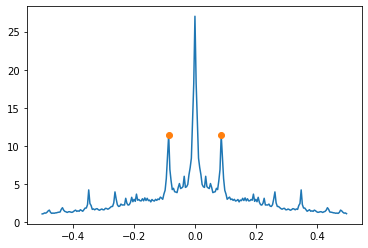

In [255]:
(ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)

def peaks_filter(x, y, peaks, k=1):
    ypeaks = y[peaks]
    xpeaks = x[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
Py = peaks_filter(yfreqs, ymean, ypeaks, 2)

plt.plot(xfreqs, xmean)
plt.plot(xfreqs[Px], xmean[Px], 'o')
plt.show()

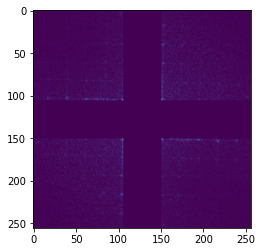

In [256]:
Xf, Yf = np.meshgrid(xfreqs, yfreqs)
mod_Xf, mod_Yf = np.abs(Xf), np.abs(Yf)
xfilter = mod_Xf > np.abs(xfreqs)[Px][0]
yfilter = mod_Yf > np.abs(yfreqs)[Py][0]
min_freqs_fft = np.where(xfilter & yfilter, fft, 0)
plt.imshow(min_freqs_fft)

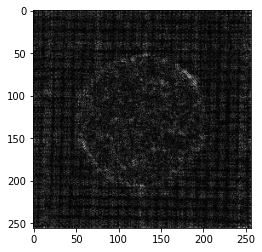

In [257]:
fourier_img = np.abs(ifft2d(np.where(xfilter & yfilter, FFT, 0)))
plt.imshow(fourier_img, cmap='gray')

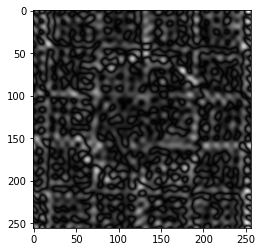

In [260]:
Pxi = peaks_filter(xfreqs, xmean, xpeaks, 1)
Pxf = peaks_filter(xfreqs, xmean, xpeaks, 2)
Pyi = peaks_filter(yfreqs, ymean, ypeaks, 1)
Pyf = peaks_filter(yfreqs, ymean, ypeaks, 2)

xpfs_i = np.abs(xfreqs)[Pxi]
xpfs_f = np.abs(xfreqs)[Pxf]
ypfs_i = np.abs(yfreqs)[Pyi]
ypfs_f = np.abs(yfreqs)[Pyf]
xfilter = (mod_Xf > xpfs_i.max()) & (mod_Xf < xpfs_f.max())
yfilter = (mod_Yf > ypfs_i.max()) & (mod_Yf < ypfs_f.max())

fourier_img = np.abs(ifft2d(np.where(xfilter & yfilter, FFT, 0)))
plt.imshow(fourier_img, cmap='gray')

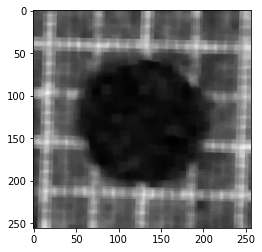

In [261]:
kn = (10, 10)
for i in range(5):
    kn = (10+i+1, 10+i+1)
    im_mean = ndimage.uniform_filter(img, kn)
    im_sqr_mean = ndimage.uniform_filter(img**2, kn)
    im_var = ndimage.minimum_filter((im_sqr_mean - im_mean**2), (i+1, i+1))
plt.imshow(im_var, cmap='gray')

In [262]:
data = im_var.flatten()
km = cluster.KMeans(3)
cluster_id = km.fit_predict(data.reshape(-1, 1))

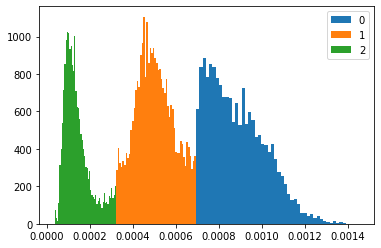

In [263]:
min_bin = None
f = 0
for ii in np.unique(cluster_id):
    subset = data[cluster_id == ii]
    hist, bins, _ = plt.hist(subset, bins=50, label=ii)
    if min_bin == None or bins.max() < min_bin:
        min_bin = bins.max()
        f = bins[:-1][hist == hist.min()]
plt.legend()
plt.show()

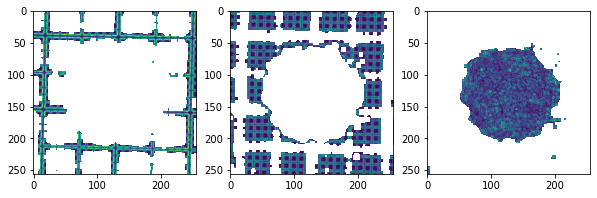

In [264]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
kernels = km.predict(im_var.flatten().reshape(-1, 1)).reshape((256, 256))
for i, ax in enumerate(axs):
    ax.imshow(np.where(kernels == i, img, np.nan))
plt.show()

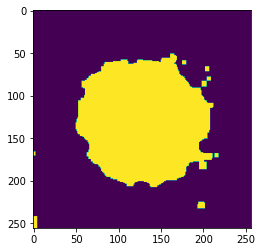

In [265]:
imth = im_var < min_bin
plt.imshow(imth)

# Variância

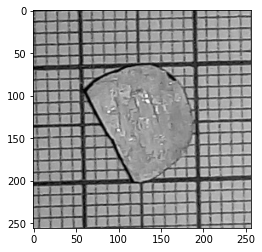

In [77]:
image = random_images()[0]#by_id(0)
img = color.rgb2gray(image) #color.rgb2gray(ndimage.gaussian_laplace(image, 3))#
plt.imshow(img, cmap='gray')

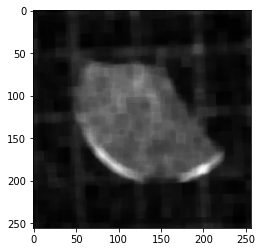

In [88]:
#im = filters.farid(img)
kn = (15, 15)
im_mean = ndimage.uniform_filter(fourier_img, kn)
im_sqr_mean = ndimage.uniform_filter(fourier_img**2, kn)
im_var = ndimage.minimum_filter((im_sqr_mean - im_mean**2), (5, 5))
plt.imshow(im_var, cmap='gray')

## Clusterização

In [89]:
data = im_var.flatten()
km = cluster.KMeans(3)
cluster_id = km.fit_predict(data.reshape(-1, 1))

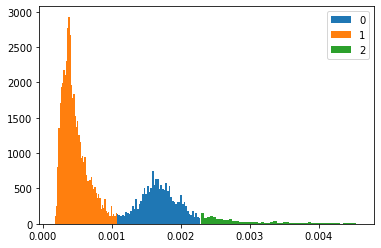

In [90]:
min_bin = None
f = 0
for ii in np.unique(cluster_id):
    subset = data[cluster_id == ii]
    hist, bins, _ = plt.hist(subset, bins=50, label=ii)
    if min_bin == None or bins.max() < min_bin:
        min_bin = bins.max()
        f = bins[:-1][hist == hist.min()]
plt.legend()
plt.show()

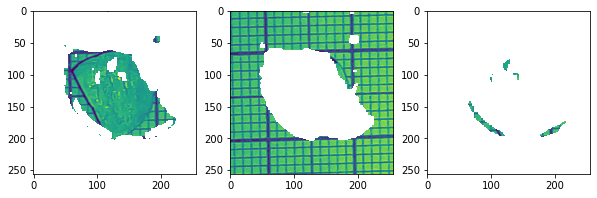

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
kernels = km.predict(im_var.flatten().reshape(-1, 1)).reshape((256, 256))
for i, ax in enumerate(axs):
    ax.imshow(np.where(kernels == i, img, np.nan))
plt.show()

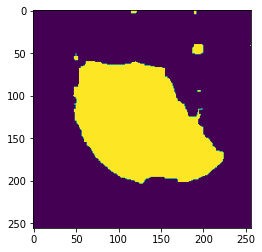

In [93]:
imth = np.logical_not(im_var < min_bin)
plt.imshow(imth)

## Ajuste morfológico

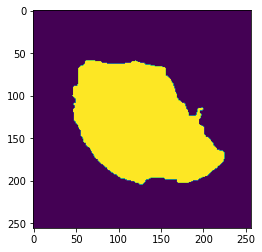

In [94]:
mask = ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


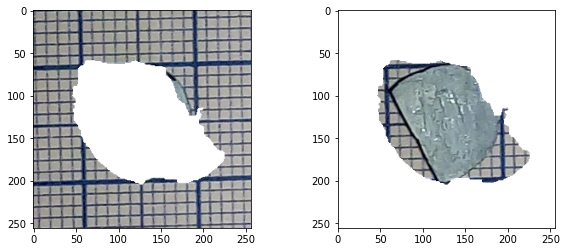

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(image/255 + mask.reshape((256, 256, 1)))
ax2.imshow(image/255 + util.invert(mask.reshape((256, 256, 1))))
plt.show()

345.jpg, 282.jpg, 53.jpg, 197.jpg, 168.jpg, 

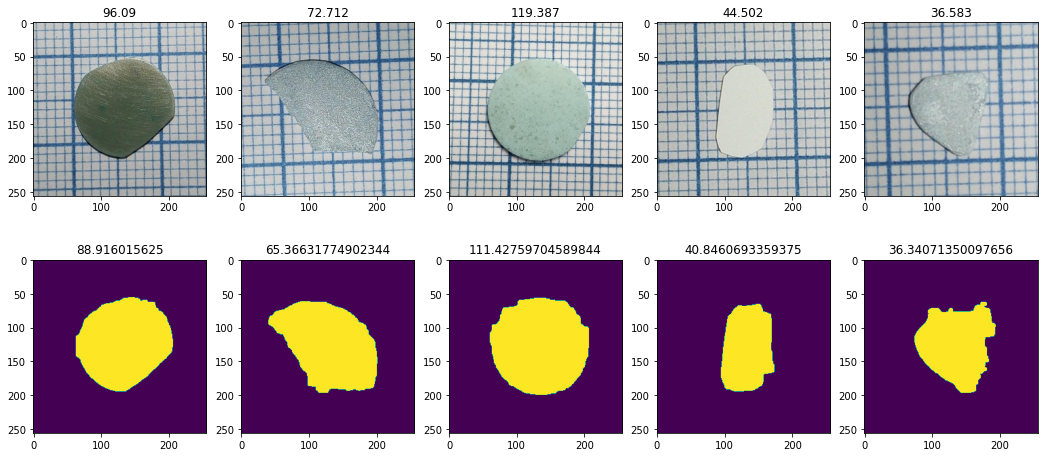

In [267]:
n = 5
fig, axs = plt.subplots(2, n, figsize=(18, 8))

for i, (img, name) in enumerate(zip(*random_images(n, names=True))):
    print(name, end=', ')
    axs[0][i].imshow(img)
    gray_img = color.rgb2gray(img)
    S = seg1(gray_img)
    axs[1][i].imshow(S)
    fx, fy = freq_peaks(gray_img)
    axs[1][i].set_title(np.sum(S)*fx*fy)
    axs[0][i].set_title(float(DS.loc[DS.filename == name].area))
    
plt.show()

# Texture-based

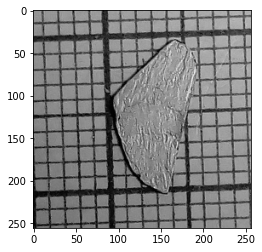

In [307]:
image = by_id(159)
img = color.rgb2gray(image)
plt.imshow(img, cmap='gray')

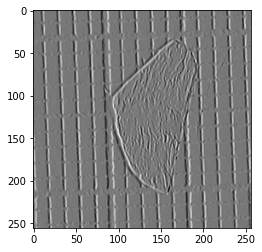

In [308]:
sobel = ndimage.sobel(img)
sobel -= sobel.min()
sobel -= sobel.max()/2
sobel /= sobel.max()
plt.imshow(sobel, cmap='gray')

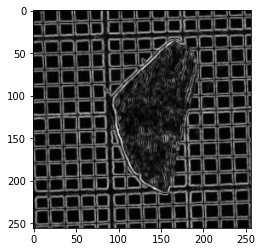

In [309]:
ent = filters.farid(img)
plt.imshow(ent, cmap='gray')

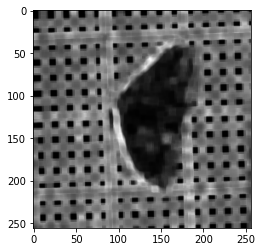

In [320]:
kn = (10, 10)
im_mean = ndimage.uniform_filter(ent, kn)
im_sqr_mean = ndimage.uniform_filter(ent**2, kn)
im_var = ndimage.minimum_filter((im_sqr_mean - im_mean**2), (3, 3))
plt.imshow(im_var, cmap='gray')

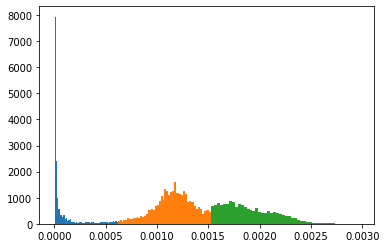

In [321]:
min_bin = None
f = 0
for ii in np.unique(cluster_id):
    subset = data[cluster_id == ii]
    hist, bins, _ = plt.hist(subset, bins=50)
    if min_bin == None or bins.max() < min_bin:
        min_bin = bins.max()
        f = bins[:-1][hist == hist.min()]
plt.show()

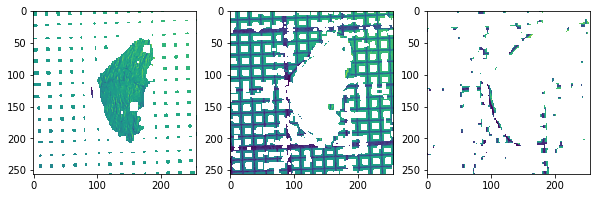

In [322]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
kernels = km.predict(im_var.flatten().reshape(-1, 1)).reshape((256, 256))
for i, ax in enumerate(axs):
    ax.imshow(np.where(kernels == i, img, np.nan))
plt.show()

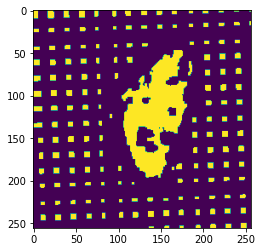

In [323]:
imth = im_var < f[0]
plt.imshow(imth)

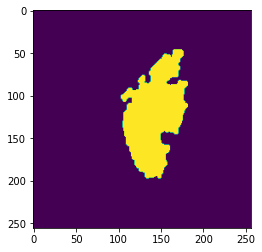

In [324]:
mask = ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
plt.imshow(mask)